In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.eos.preselection.t8btag_minmass
dout = "ranked_quadh"

In [5]:
signal = ObjIter([ Tree(f) for f in module.signal_list ])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])
data = ObjIter([ Tree(module.JetHT_Data_UL_List) ])

100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
def n_presel_jet(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jet)

[None, None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)

t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
path = f"/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221115_ranger_lr0.0047_batch512_m7m10m12/"


In [10]:
(signal+bkg+data).apply(lambda t : eightb.load_quadh(t, path), report=True)
# (signal).apply(lambda t : eightb.load_quadh(t, path), report=True)


100%|██████████| 6/6 [00:38<00:00,  6.39s/it]


[None, None, None, None, None, None]

In [11]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)
signal.apply(nfound_higgs)

[None, None, None]

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


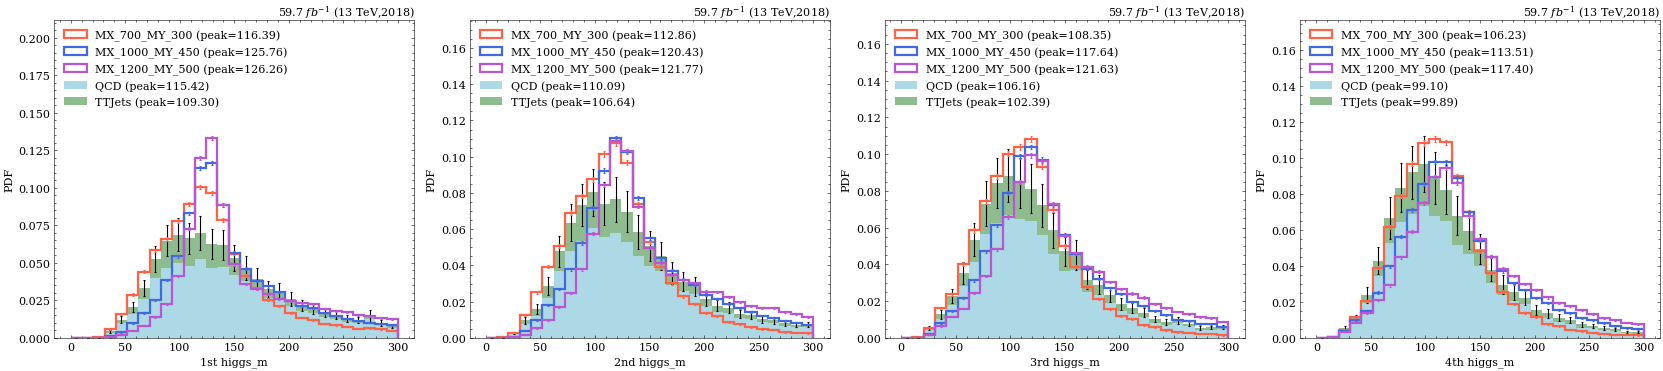

In [12]:
study.quick(
    signal+bkg,
    # signal,
    legend=True, 
    h_fit='gaussian',
    h_fit_peak=True,
    h_label_stat='peak={fit.mu:0.2f}',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m'
)

In [13]:
select_jetpt = eightb.selected_jet_ptregressed()

signal = signal.apply(select_jetpt)
bkg = bkg.apply(select_jetpt)

ValueError: key "genWeight" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/util.cpp#L525)

In [14]:
data = data.apply(select_jetpt)


100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


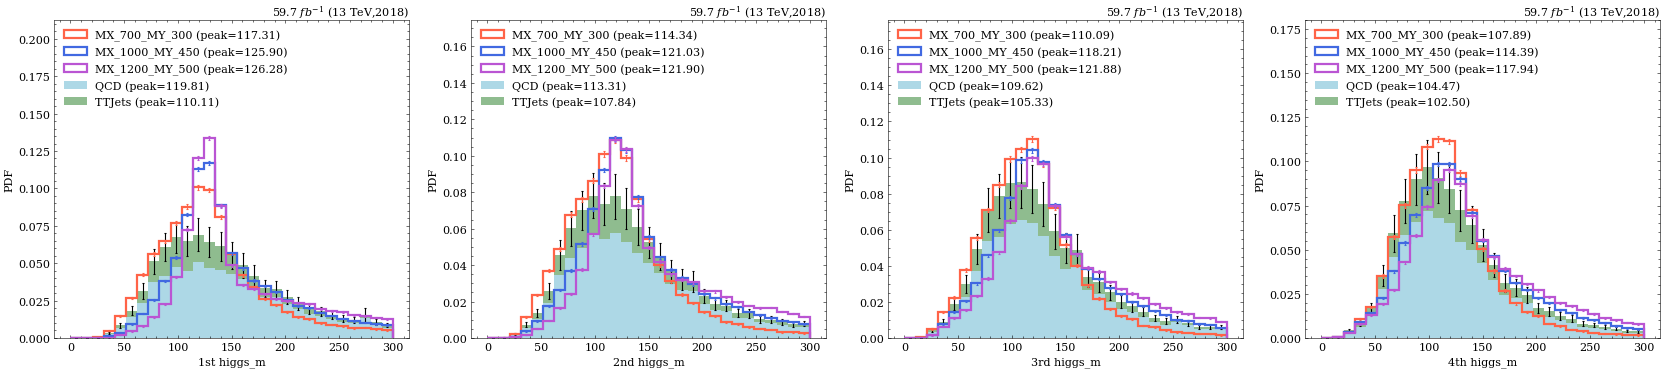

In [15]:
study.quick(
    signal+bkg,
    # signal,
    legend=True, 
    h_fit='gaussian',
    h_fit_peak=True,
    h_label_stat='peak={fit.mu:0.2f}',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m_jet_pt_cuts'
)

In [16]:
select_jetbtagwp = eightb.selected_jet_btagwp()

signal = signal.apply(select_jetbtagwp)
bkg = bkg.apply(select_jetbtagwp)
data = data.apply(select_jetbtagwp)

100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


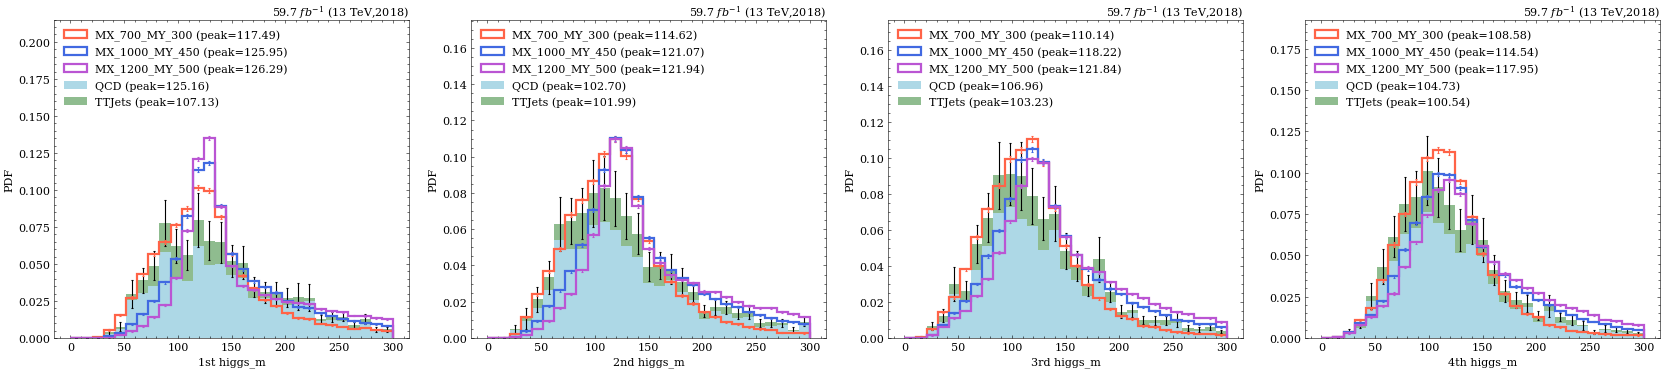

In [17]:
study.quick(
    signal+bkg,
    # signal,
    legend=True, 
    h_fit='gaussian',
    h_fit_peak=True,
    h_label_stat='peak={fit.mu:0.2f}',
    varlist=[f'higgs_m[:,{i}]' for i in range(4)],
    binlist=[(0,300,30)]*4,
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/higgs_m_jet_btag_cuts'
)

100%|██████████| 2/2 [00:00<00:00,  9.34it/s]


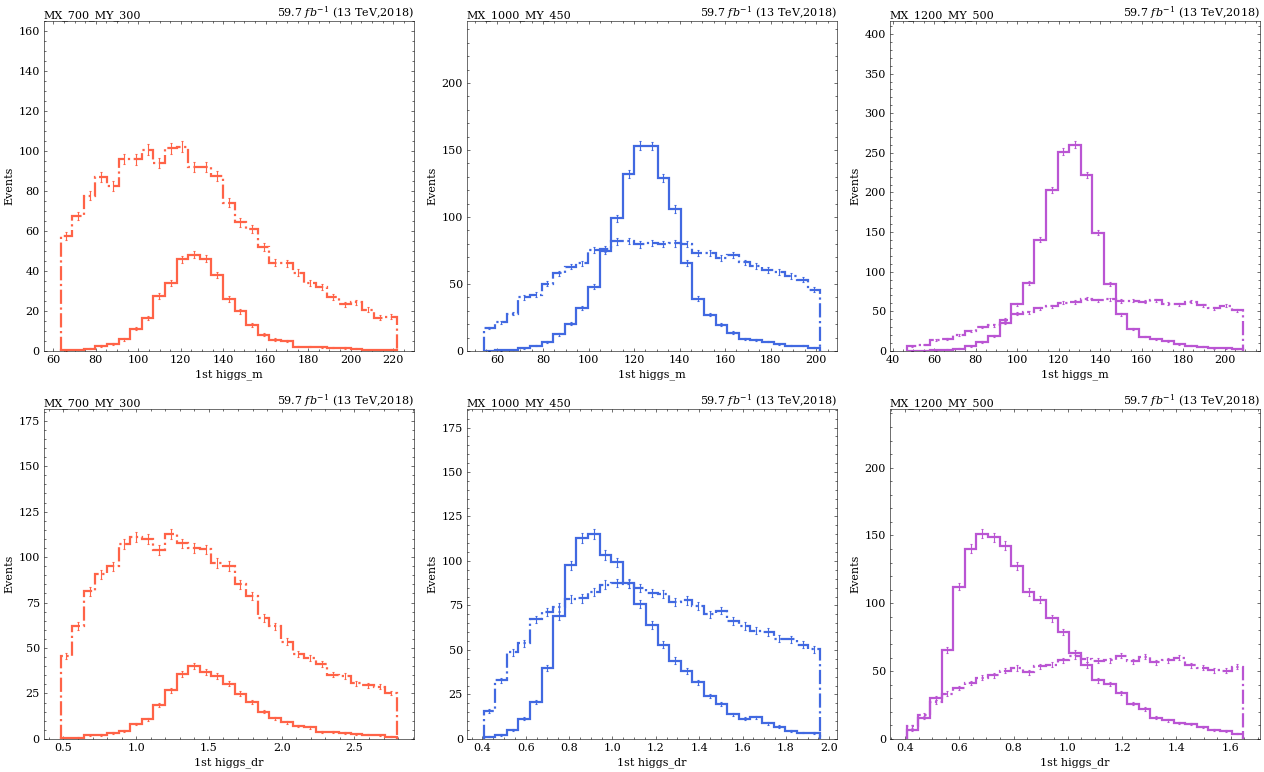

In [18]:
i = 0
study.compare_masks( 
    signal,
    masks=[lambda t : t.higgs_signalId[:,i] > -1, lambda t : t.higgs_signalId[:,i] == -1],
    label=['true higgs','fake higgs'],
    varlist=[ f'higgs_{var}[:,{i}]' for var in ('m','dr') ]
)

In [1]:
study.quick2d( 
    signal,
    masks=lambda t : t.higgs_signalId[:,0] > -1,
    varlist=['higgs_dr[:,0]','higgs_m[:,0]'],
    exe=plot_histo2d_x_corr,
    scatter=True,
)

study.quick2d( 
    signal,
    masks=lambda t : t.higgs_signalId[:,0] == -1,
    varlist=['higgs_dr[:,0]','higgs_m[:,0]'],
    exe=plot_histo2d_x_corr,
    scatter=True,
)

NameError: name 'study' is not defined

100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


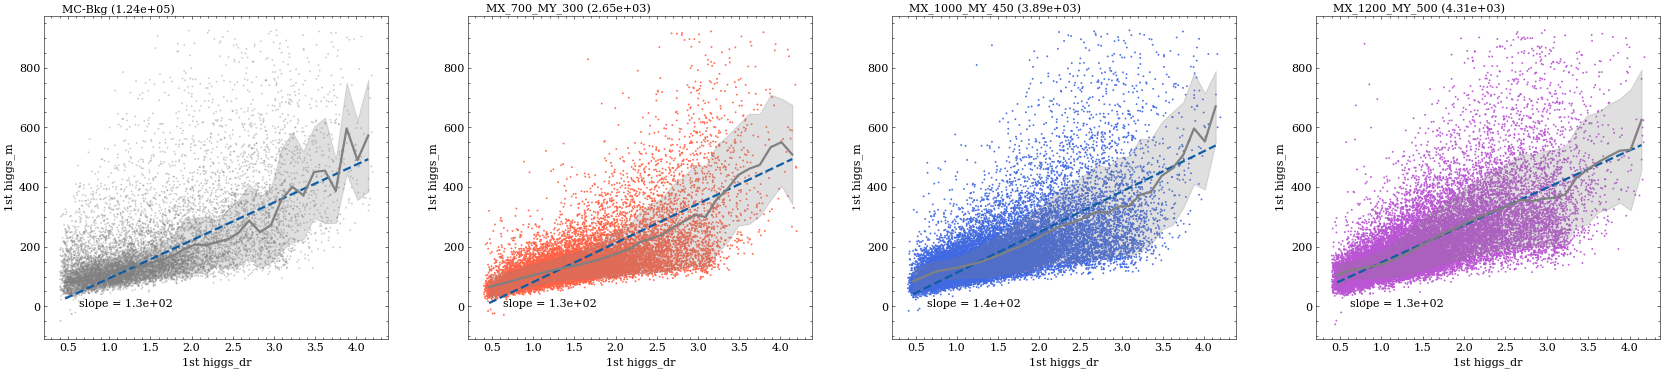

In [ ]:
study.quick2d( 
    signal+bkg,
    varlist=['higgs_dr[:,0]','higgs_m[:,0]'],
    exe=plot_histo2d_x_corr,
    scatter=True,
)

100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


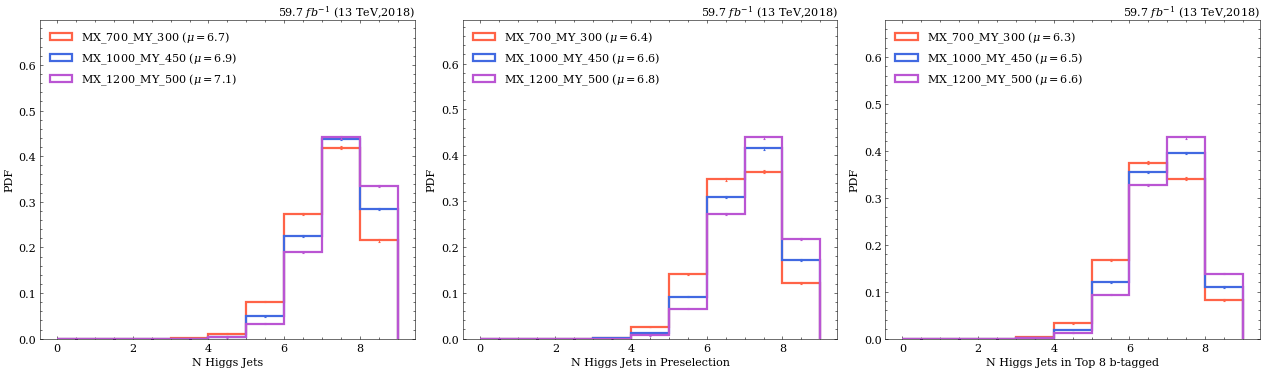

In [ ]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    efficiency=True,
    varlist=['nfound_all','nfound_presel','nfound_select'],
    xlabels=['N Higgs Jets','N Higgs Jets in Preselection','N Higgs Jets in Top 8 b-tagged'],
    dim=-1,
    saveas=f'{dout}/n_higgs_jets'
)

In [ ]:
njets_lost = lambda t:t.nfound_presel-t.nfound_select

def frac_events(t):
    nlost = njets_lost(t)
    return f"{ak.mean(nlost>0):0.2%}"

signal.apply(frac_events)

['13.84%', '17.28%', '18.93%']

100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


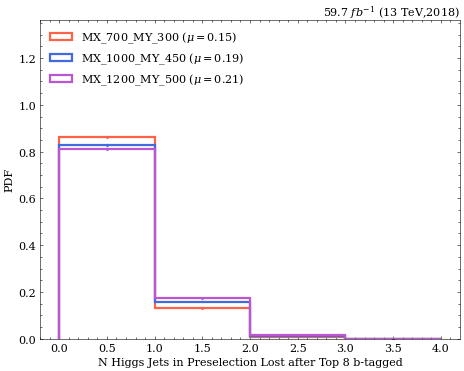

In [ ]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=[njets_lost],
    xlabels=['N Higgs Jets in Preselection Lost after Top 8 b-tagged'],
    dim=-1,
    efficiency=True,
    saveas=f'{dout}/n_higgs_jets_lost'
)

100%|██████████| 3/3 [00:04<00:00,  1.43s/it]


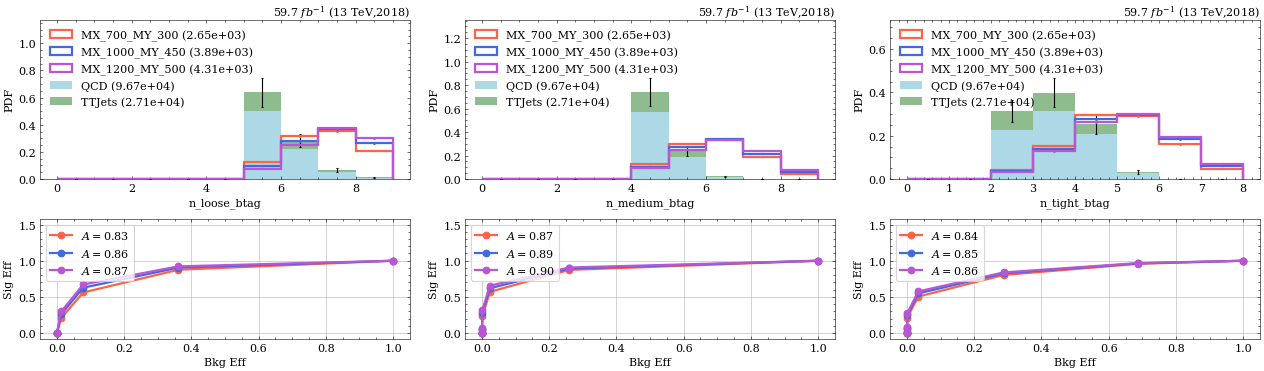

In [ ]:
study.quick(
    bkg+signal, legend=True,
    varlist=['n_loose_btag','n_medium_btag','n_tight_btag'],
    efficiency=True, dim=-1,
    **study.auroc,

    saveas=f'{dout}/btag_multi'
)

100%|██████████| 4/4 [00:00<00:00,  5.41it/s]


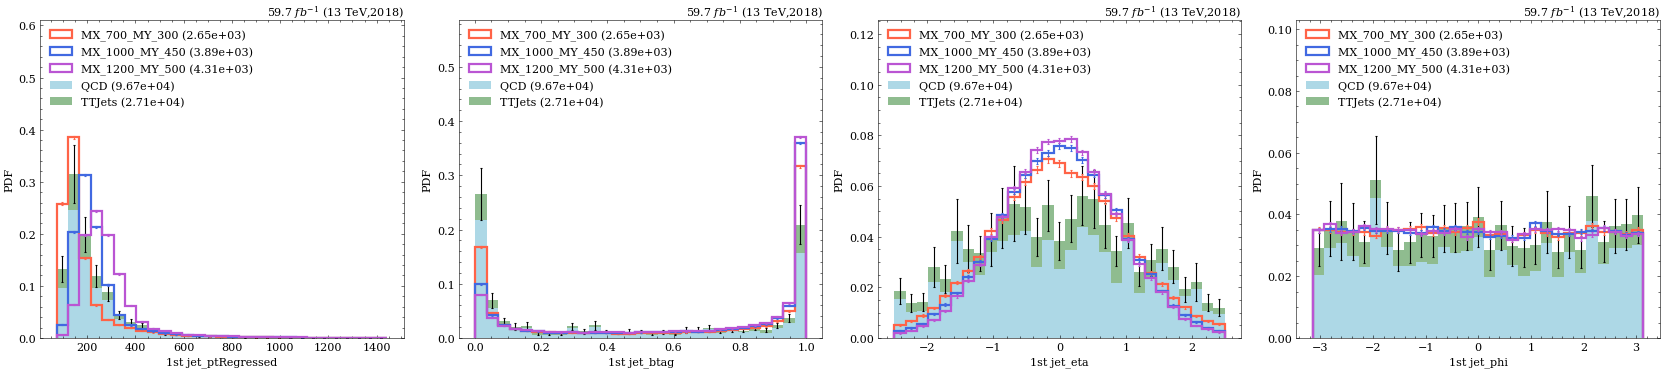

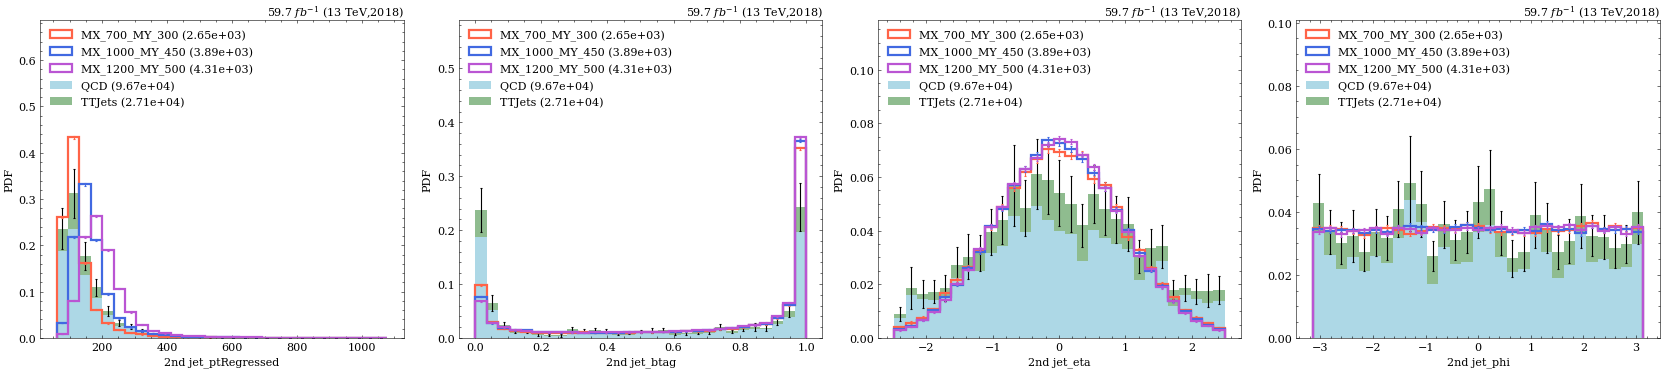

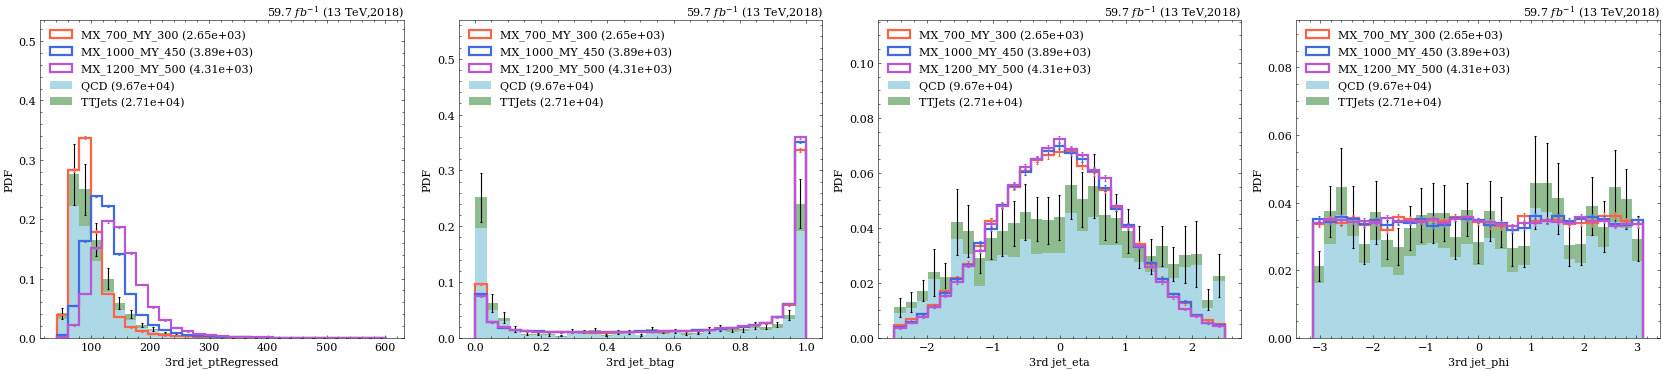

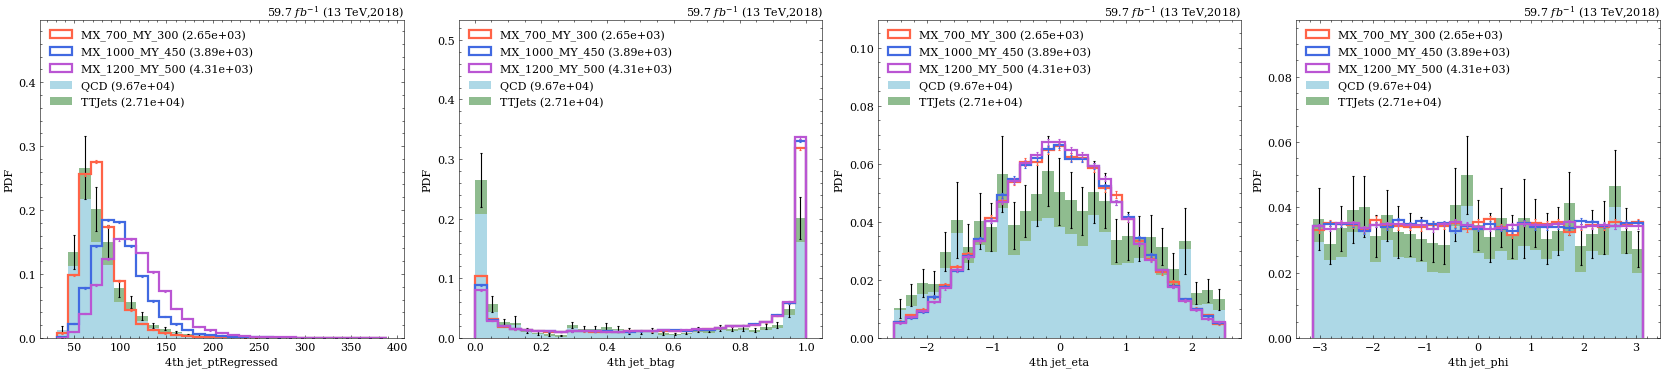

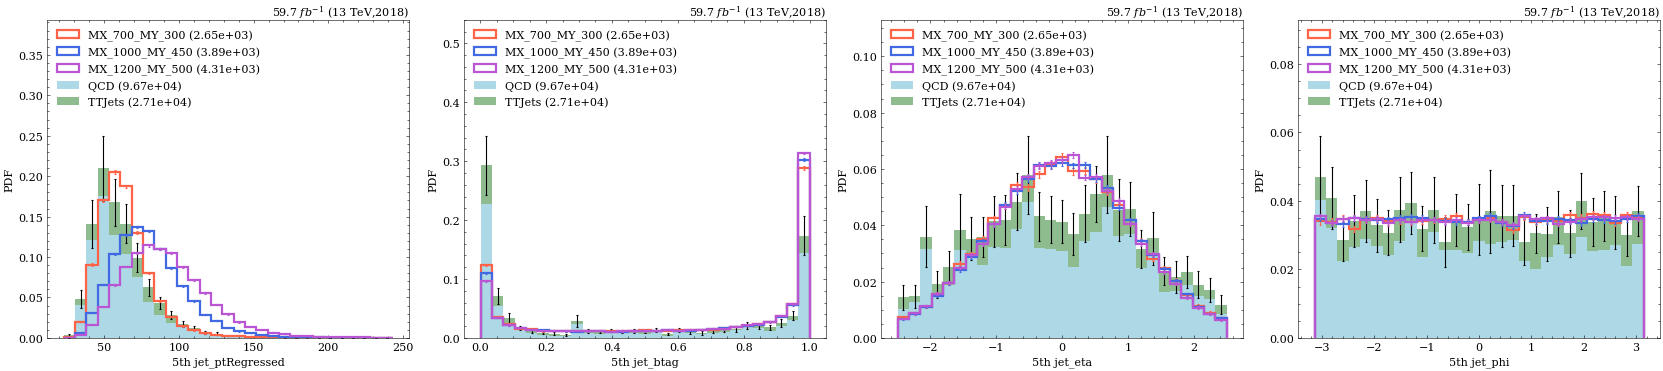

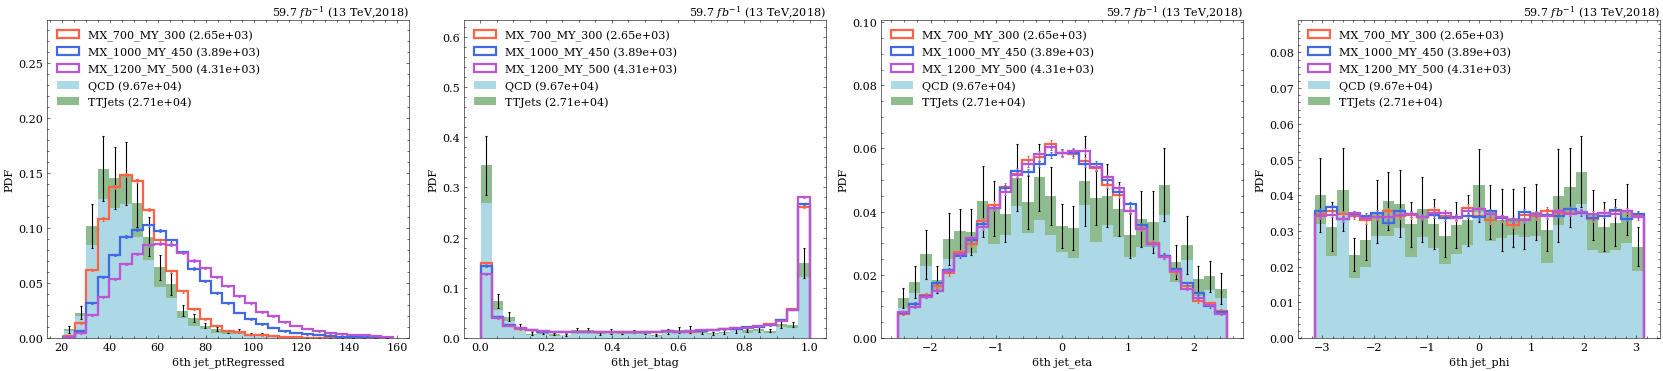

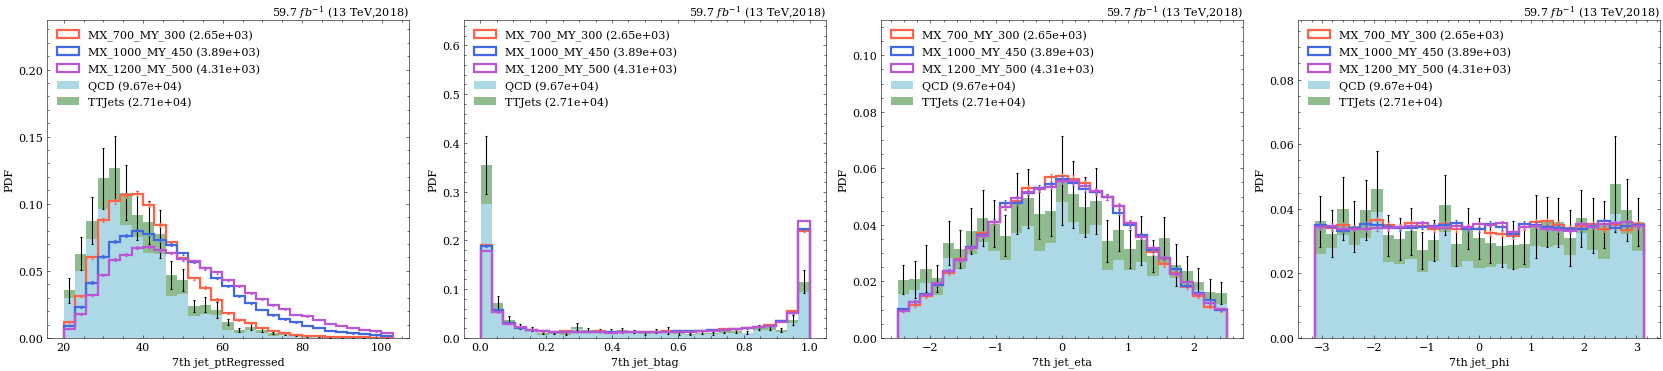

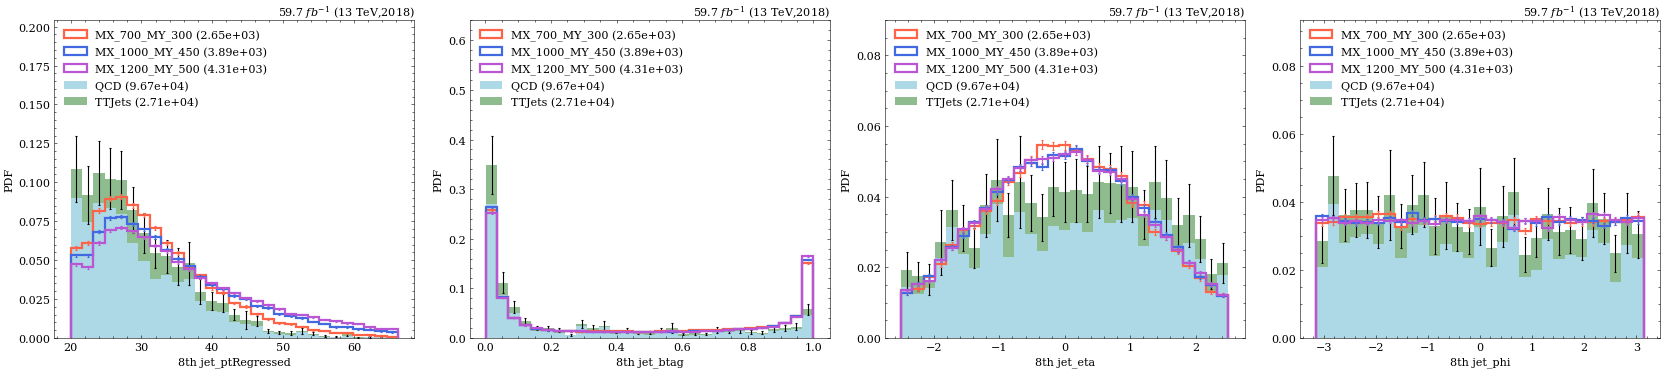

In [ ]:
for i in range(8):
    study.quick( 
        signal+bkg, legend=True, 
        varlist=[f'jet_{var}[:,{i}]' for var in ('ptRegressed','btag','eta','phi')],
        efficiency=True,
        dim=-1,
        saveas=f'{dout}/{ordinal(i)}_pt_jet'
    )

In [ ]:
varinfo.higgs_dr = dict(bins=(0,5,30))
varinfo.higgs_m = dict(bins=(0,300,30))

100%|██████████| 5/5 [00:00<00:00,  5.13it/s]


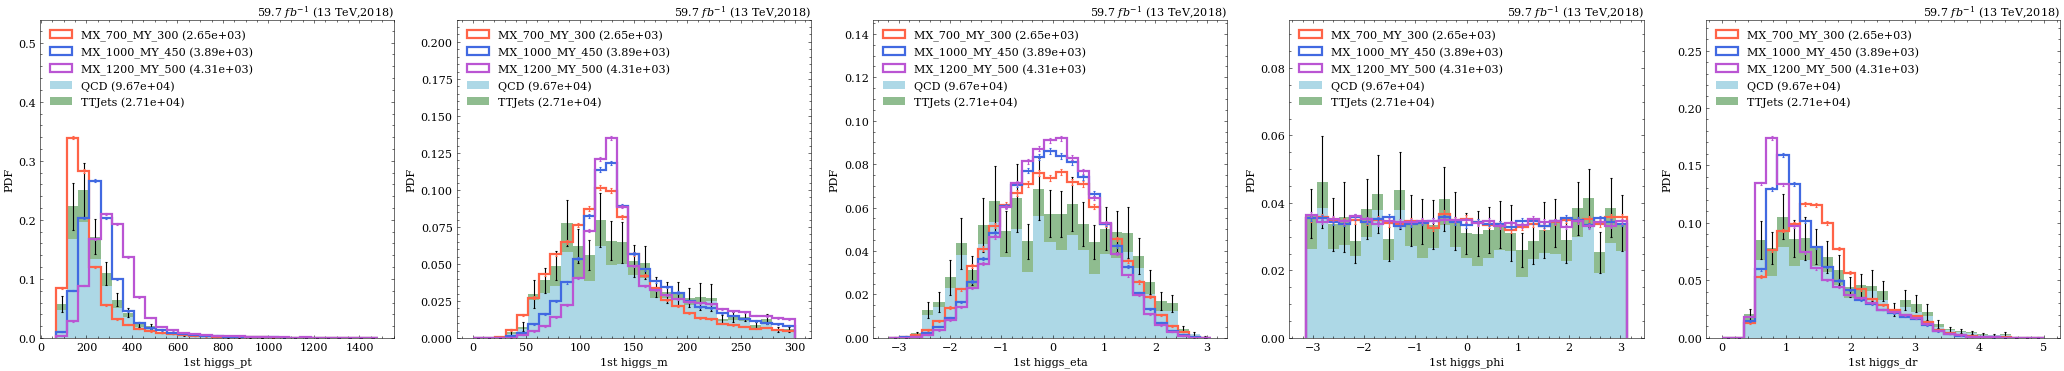

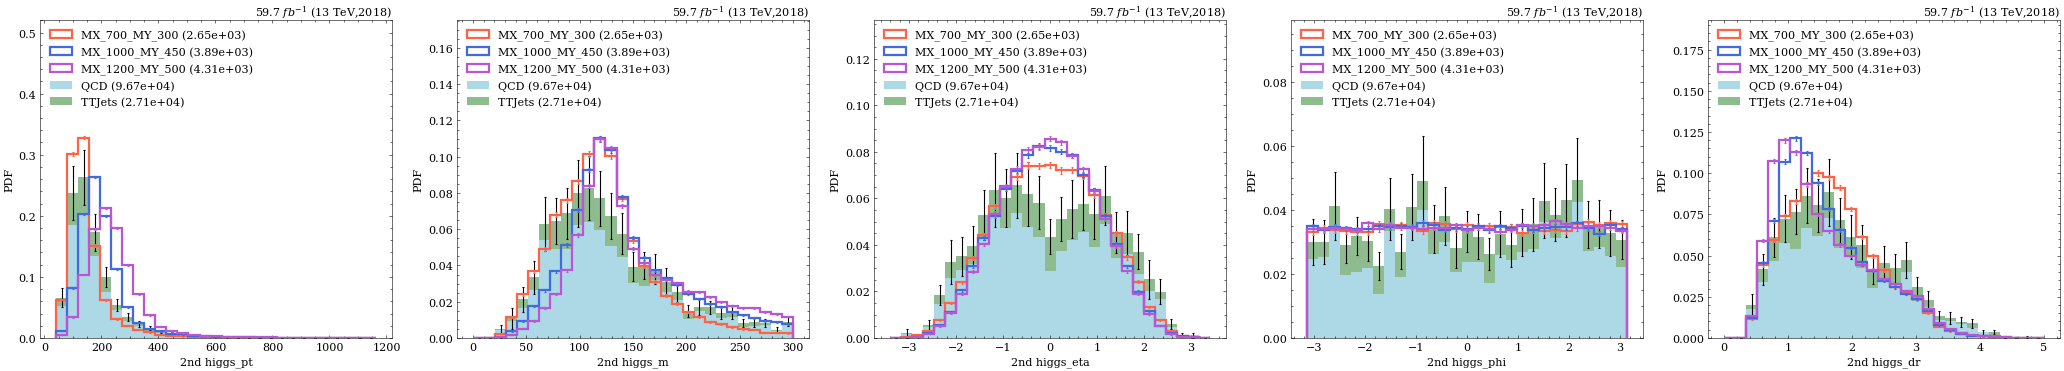

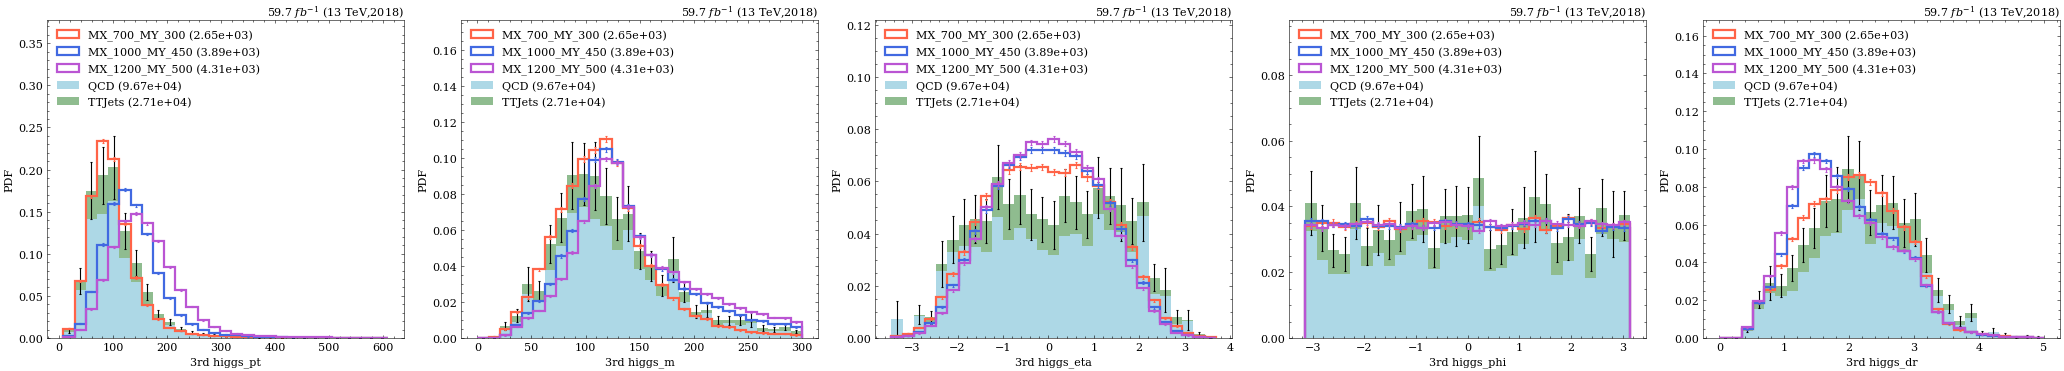

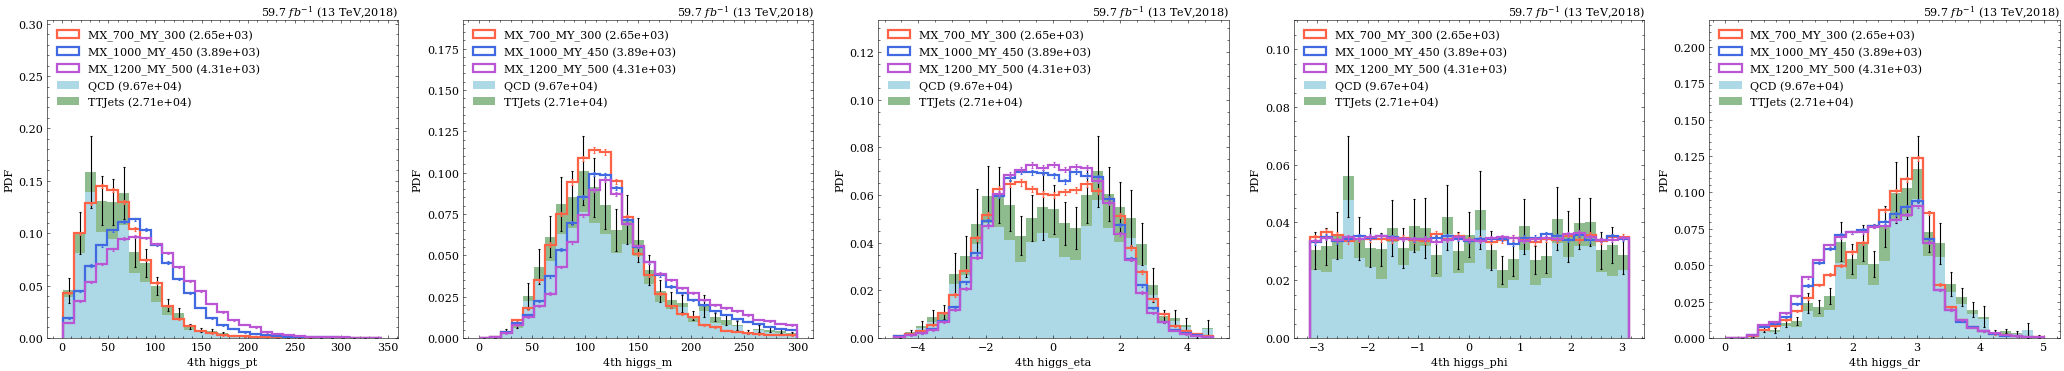

In [ ]:
for i in range(4):
    study.quick( 
        signal+bkg, 
        # signal, 
        legend=True, efficiency=True,
        varlist=[f'higgs_{var}[:,{i}]' for var in ('pt','m','eta','phi','dr')],
        dim=-1,
        saveas=f'{ordinal(i)}_pt_higgs'
    )

In [ ]:
# for i in range(2):
#     study.quick( 
#         signal+bkg, legend=True, efficiency=True,
#         varlist=[f'Y{i+1}_{var}' for var in ('pt','m','eta','phi')],
#         dim=-1,
#         saveas=f'{dout}/{ordinal(i)}_pt_y'
#     )

In [ ]:
varinfo.X_m = dict(bins=(500,2000,30))

100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


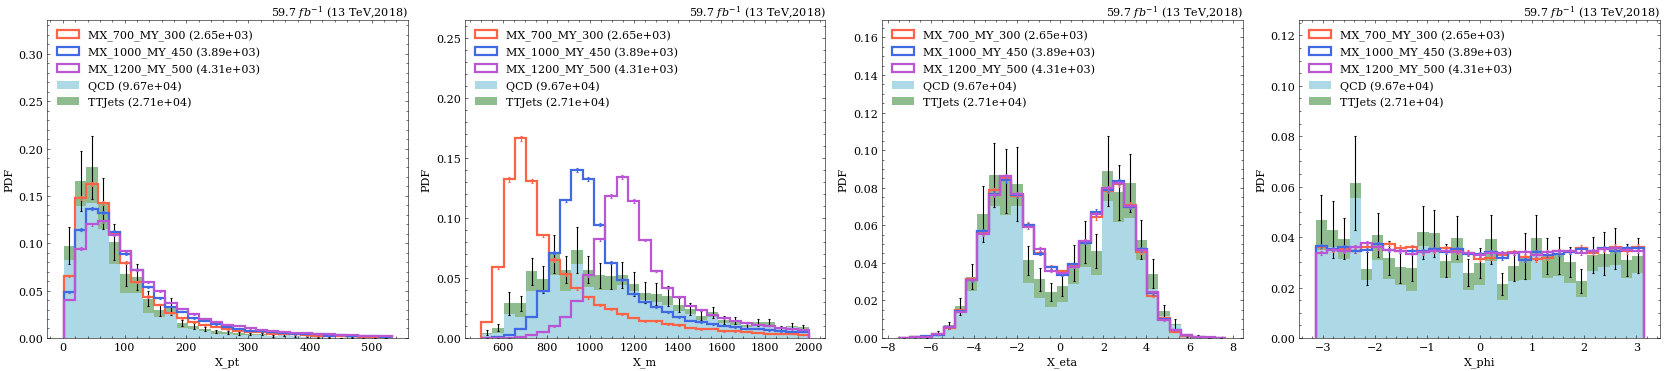

In [ ]:
study.quick( 
    signal+bkg, legend=True, efficiency=True,
    varlist=[f'X_{var}' for var in ('pt','m','eta','phi')],
    dim=-1,
    saveas=f'{dout}/X'
)

100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


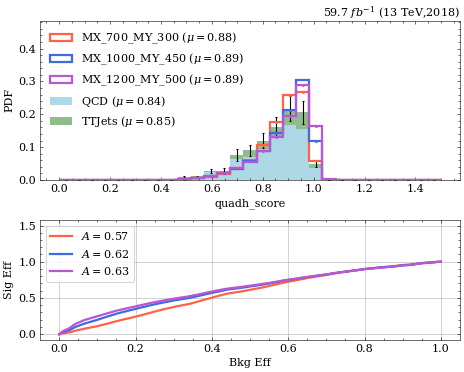

In [ ]:
study.quick(
    signal+bkg, 
    legend=True,
    h_label_stat='mean',
    # log=True, 
    efficiency=True,
    varlist=['quadh_score'],
    binlist=[(0,1.5,30)],
    # xlabels=['Minimum Higgs Mass Asymmetry'],

    **study.auroc,
    saveas=f'{dout}/quadh_score_roc',
)

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


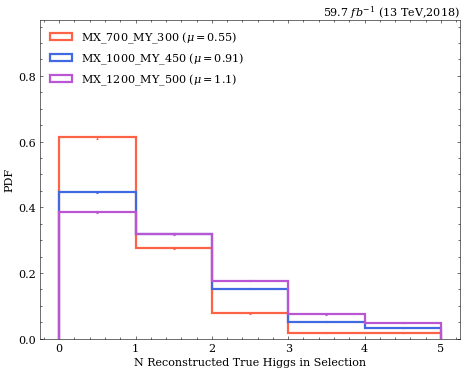

In [ ]:
study.quick(
    signal, legend=True, h_label_stat='mean',
    varlist=['nfound_paired_h'],
    efficiency=True,
    xlabels=['N Reconstructed True Higgs in Selection'],
    saveas=f'{dout}/n_higgs_reco',
)

100%|██████████| 1/1 [00:23<00:00, 23.66s/it]


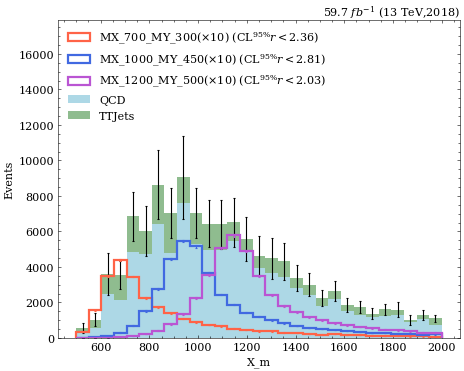

In [ ]:
study.quick(
    signal+bkg, legend=True,
    plot_scale=[10]*len(signal),
    varlist=['X_m'],
    limits=True,
    saveas=f'{dout}/limits/no_cuts'
)

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


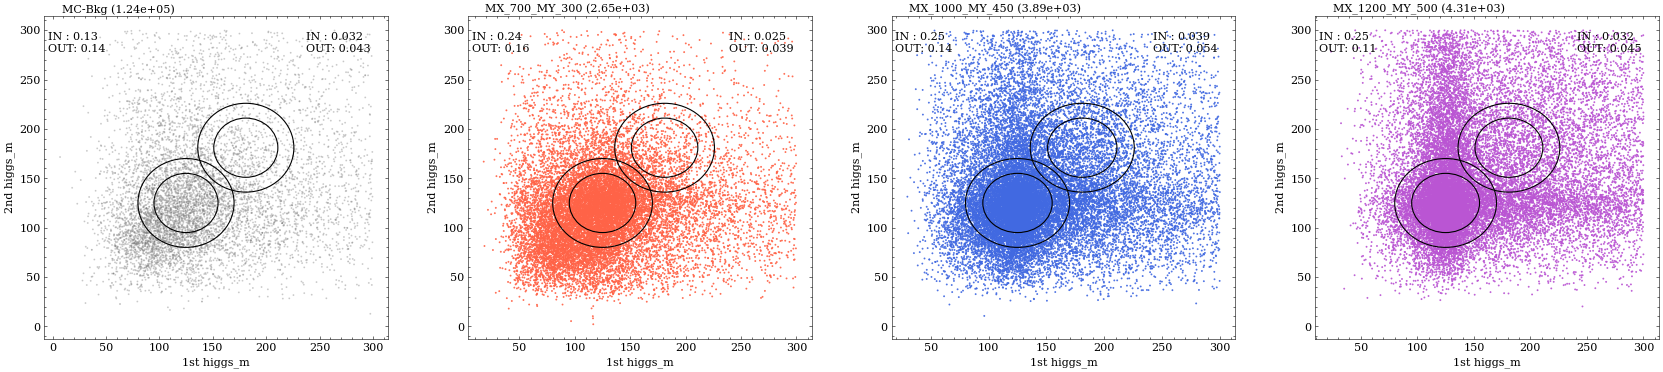

In [ ]:
study.quick2d(
    signal+bkg,
    varlist=['higgs_m[:,0]','higgs_m[:,1]'],
    binlist=[(0,300,15)]*2,
    exe=[
        draw_concentric(x=125,y=125,r1=30, r2=45, color='green'),
        draw_concentric(x=181,y=181,r1=30, r2=45, text=(0.75,0.95), color='black'),
    ],
    scatter=True,
)

In [ ]:
def higgs_dm(t, r = (125,125)):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(higgs_dm = dm)
(signal+bkg).apply(higgs_dm)

[None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


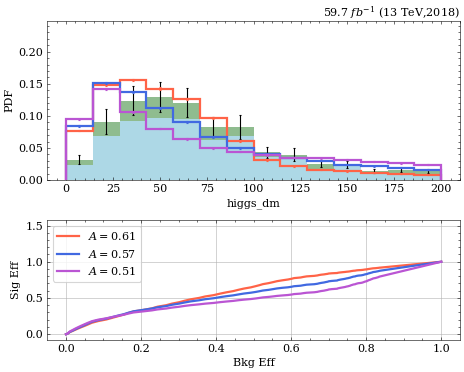

In [ ]:
study.quick(
    signal+bkg,
    varlist=['higgs_dm'],
    binlist=[(0,200,15)]*2,
    efficiency=True,
    **study.auroc, 
)

In [ ]:
varinfo.X_m = dict(bins=(500,2000,15))

In [ ]:
def val_higgs_dm(t, r = (181,181)):
    dm = ak.zeros_like(t.Run)
    for i, m in enumerate(r):
        dm = dm + ( t.higgs_m[:,i] - m )**2
    dm = np.sqrt(dm)
    t.extend(val_higgs_dm = dm)
(signal+bkg+data).apply(val_higgs_dm)

[None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


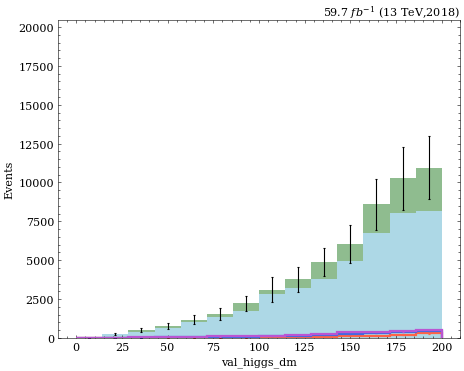

In [ ]:
study.quick(
    signal+bkg,
    masks=lambda t:t.val_higgs_dm<45,
    varlist=['val_higgs_dm'],
    binlist=[(0,45,15)]*2,
    # efficiency=True,
    # **study.auroc, 
)

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


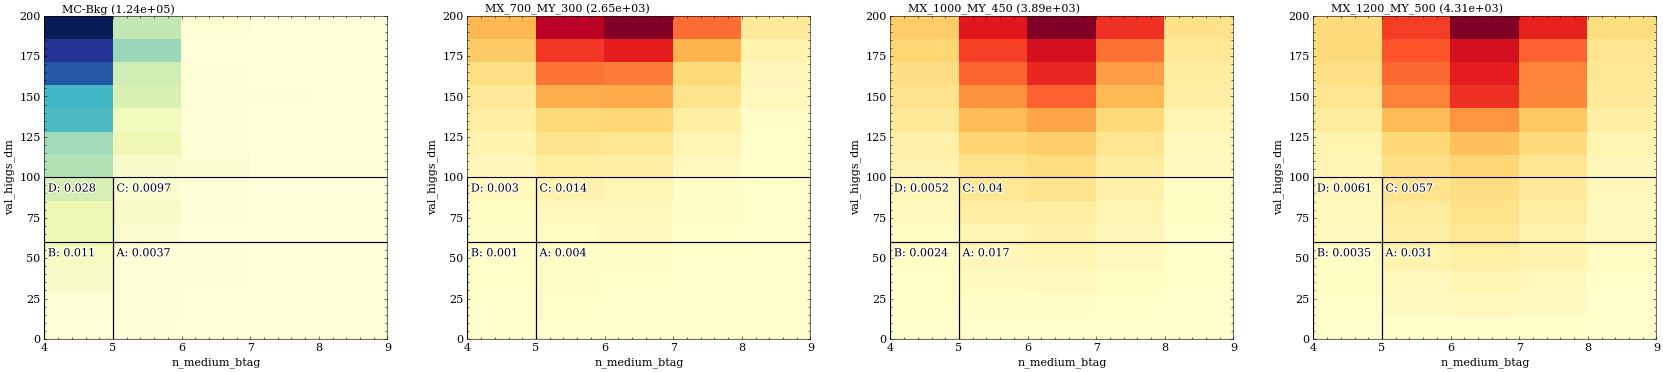

In [50]:
study.quick2d(
    signal+bkg, 
    varlist=['n_medium_btag','val_higgs_dm',],
    binlist=[np.arange(4,10),(0,200,15)],
    exe=draw_abcd(x_r=(4,5,9), y_r=(0,60,100), regions=["C","D","A","B"])
)

In [51]:
def event_variables(t):
    t.extend(
        jet_ht = ak.sum(t.jet_ptRegressed,axis=-1)
    )
(signal+bkg).apply(event_variables)

[None, None, None, None, None]

In [52]:
val_bdt = ABCD(
    features=['jet_ht','higgs_m[:,0]'],
    a = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm < 60),
    b = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm < 60),
    c = lambda t : (t.n_medium_btag >  4) & (t.val_higgs_dm > 60) & (t.val_higgs_dm < 100),
    d = lambda t : (t.n_medium_btag <= 4) & (t.val_higgs_dm > 60) & (t.val_higgs_dm < 100),
)

  0%|          | 0/1 [00:00<?, ?it/s]ERROR:pyhf.optimize.mixins:     fun: nan
     jac: array([nan,  0.,  0.,  0.])
 message: 'Inequality constraints incompatible'
    nfev: 1
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 1., 1., 1.])
Traceback (most recent call last):
  File "/uscms_data/d3/ekoenig/mambaforge/envs/py-env/lib/python3.9/site-packages/pyhf/optimize/mixins.py", line 61, in _internal_minimize
    assert result.success
AssertionError
ERROR:pyhf.optimize.mixins:     fun: nan
     jac: array([nan,  0.,  0.,  0.])
 message: 'Inequality constraints incompatible'
    nfev: 1
     nit: 1
    njev: 1
  status: 4
 success: False
       x: array([0., 1., 1., 1.])
Traceback (most recent call last):
  File "/uscms_data/d3/ekoenig/mambaforge/envs/py-env/lib/python3.9/site-packages/pyhf/optimize/mixins.py", line 61, in _internal_minimize
    assert result.success
AssertionError
ERROR:pyhf.optimize.mixins:     fun: nan
     jac: array([nan,  0.,  0.,  0.])
 mes

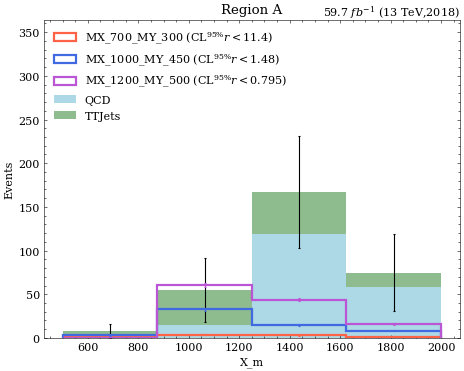

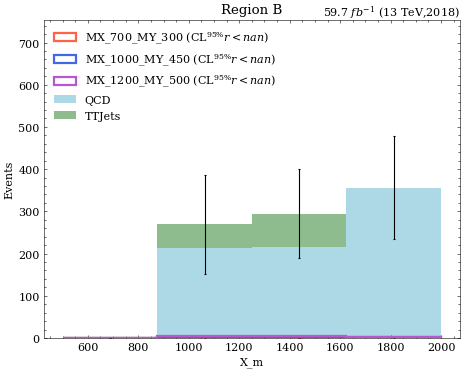

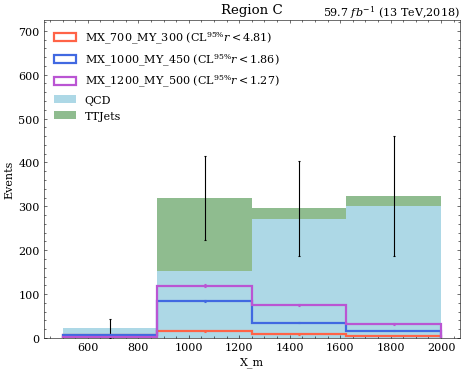

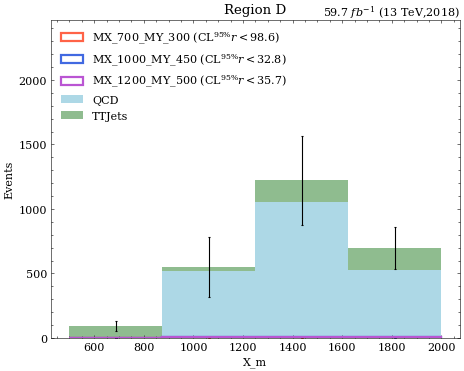

In [54]:
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        # plot_scale=[10]*len(signal),
        masks=getattr(val_bdt,r),
        varlist=['X_m'],
        binlist=[(500,2000,5)],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [98]:
bdt = ABCD(
    features=['jet_ht','higgs_m[:,0]'],
    a = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm < 60),
    b = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm < 60),
    c = lambda t : (t.n_medium_btag >  4) & (t.higgs_dm > 60) & (t.higgs_dm < 100),
    d = lambda t : (t.n_medium_btag <= 4) & (t.higgs_dm > 60) & (t.higgs_dm < 100),
)

100%|██████████| 1/1 [00:15<00:00, 15.88s/it]


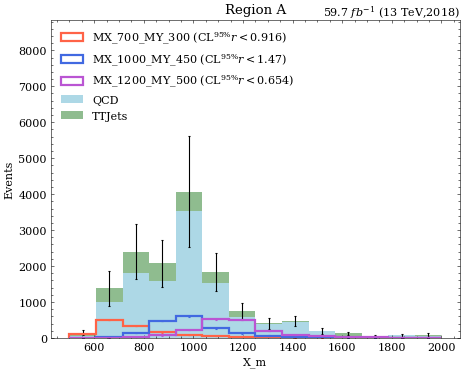

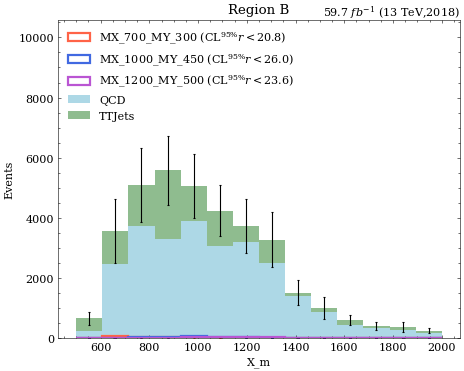

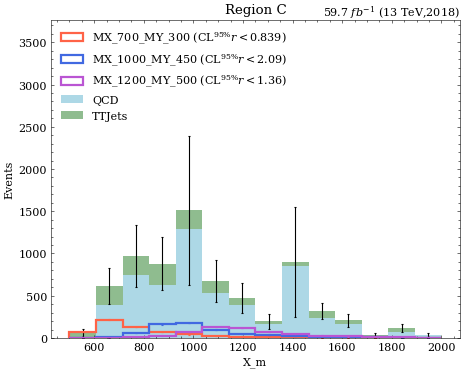

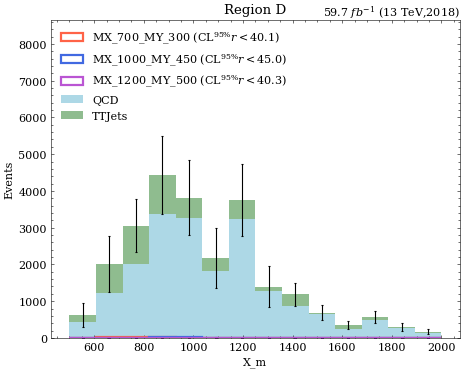

In [99]:
for r in ('a','b','c','d'):
    study.quick(
        signal + bkg, 
        legend=True,
        # plot_scale=[10]*len(signal),
        masks=getattr(bdt,r),
        varlist=['X_m'],
        limits=True,
        title=f'Region {r.upper()}',
        saveas=f'{dout}/limits/region_{r}'
    )

In [100]:
bdt.train(bkg)
bdt.print_results(bkg)

--- ABCD Results ---
k = 2.840e-01
k*(b/a)-1  = -28.65%
BDT(b)/a-1 = -28.65%



100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


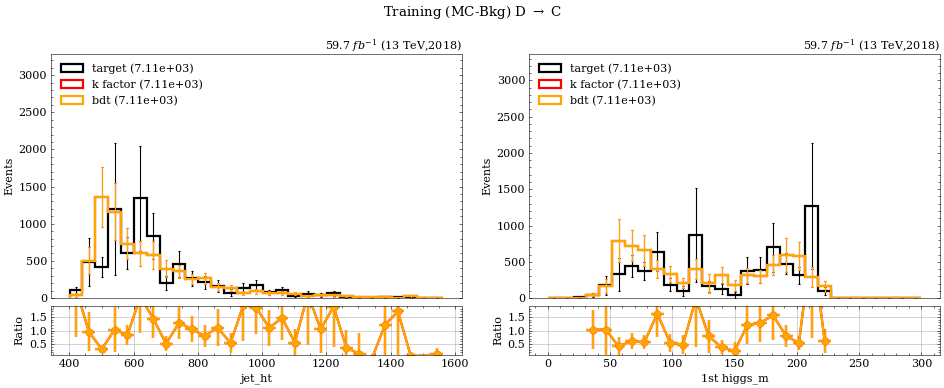

In [101]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','red','orange'], legend=True,
    masks=[bdt.c]*len(bkg)+[bdt.d]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Training (MC-Bkg) D $\\rightarrow$ C',
    ratio=True,
    saveas=f'{dout}/bdt/training'
)

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


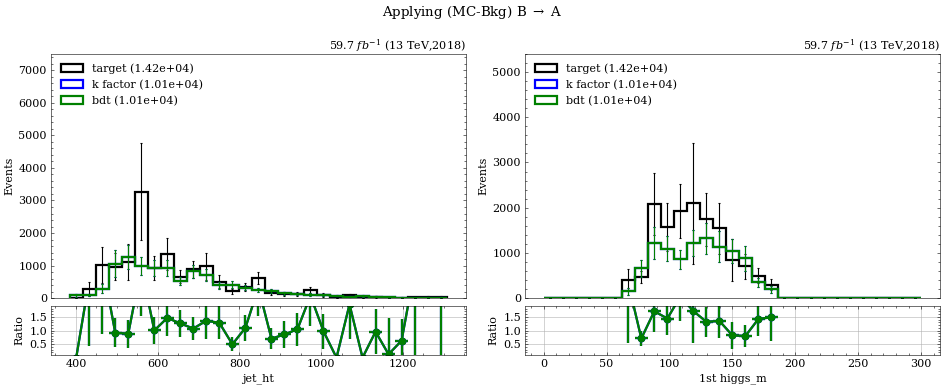

In [102]:
study.quick_region(
    bkg, bkg, bkg, label=['target','k factor','bdt'],
    h_color=['black','blue','green'], legend=True,
    masks=[bdt.a]*len(bkg)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(bkg)+[bdt.scale_tree]*len(bkg)+[bdt.reweight_tree]*len(bkg),
    varlist=bdt.feature_names,
    suptitle='Applying (MC-Bkg) B $\\rightarrow$ A',
    saveas=f'{dout}/bdt/applying',
    ratio=True,
)

100%|██████████| 1/1 [00:14<00:00, 14.20s/it]


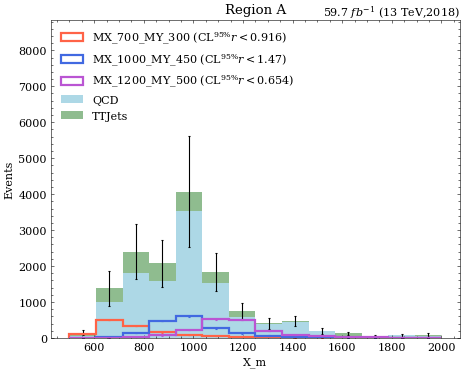

In [103]:
study.quick(
    signal + bkg, 
    legend=True,
    masks=bdt.a,
    varlist=['X_m'],
    limits=True,
    title='Region A',
    saveas=f'{dout}/limits/region_a'
)

100%|██████████| 1/1 [00:13<00:00, 13.65s/it]


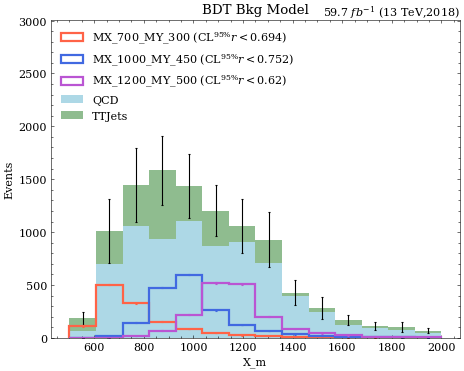

In [104]:
study.quick(
    signal + bkg, 
    legend=True,
    masks=[bdt.a]*len(signal)+[bdt.b]*(len(bkg)*2),
    scale=[1]*len(signal)+[bdt.reweight_tree]*len(bkg),
    varlist=['X_m'],
    title='BDT Bkg Model',
    limits=True,
    saveas=f'{dout}/limits/bdt_bkg_model'
)